In [ ]:
import os
import time
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

IMAGE_SHAPE = (128, 128, 3)
NOISE_DIM = 100
BATCH_SIZE = 128
EPOCHS = 50
DATA_PATH = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'

def preprocess_image(file_path):
    img_raw = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
    return img

def load_celeba_images(path):
    all_files = [os.path.join(path, f) for f in os.listdir(path)[:10000] if f.endswith('.jpg')]
    dataset = tf.data.Dataset.from_tensor_slices(all_files)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    images_list = []
    for batch in tqdm(dataset.batch(1024).prefetch(tf.data.AUTOTUNE)):
        images_list.append(batch)

    return tf.concat(images_list, axis=0)

images = load_celeba_images(DATA_PATH)
dataset = tf.data.Dataset.from_tensor_slices(images) \
                         .shuffle(buffer_size=50000) \
                         .batch(BATCH_SIZE) \
                         .prefetch(tf.data.AUTOTUNE)

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator(NOISE_DIM=NOISE_DIM):
    model = tf.keras.Sequential([
        # 1) Start with a dense layer that reshapes to 8x8 with 512 channels
        layers.Dense(8*8*512, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.Reshape((8, 8, 512)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 2) Upsample to 16x16
        layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 3) Upsample to 32x32
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 4) Upsample to 64x64
        layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 5) Upsample to 128x128
        layers.Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 6) Final layer → 128x128x3, use tanh for output in [-1,1]
        layers.Conv2DTranspose(3, (4,4), strides=(1,1), padding='same', use_bias=False, activation='tanh')
    ], name="Generator")

    return model


def build_discriminator():
    model = tf.keras.Sequential([
        # 1) Downsample from 128x128 to 64x64
        layers.Conv2D(64, (4,4), strides=(2,2), padding='same',
                      input_shape=(128,128,3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 2) Downsample to 32x32
        layers.Conv2D(128, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 3) Downsample to 16x16
        layers.Conv2D(256, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 4) Downsample to 8x8
        layers.Conv2D(512, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # 5) Flatten to a single logit
        layers.Flatten(),
        layers.Dense(1)
    ], name="Discriminator")

    return model

In [ ]:
generator = build_generator()
discriminator = build_discriminator()


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # Ensure shapes match
        assert generated_images.shape[1:] == IMAGE_SHAPE, "Generated image shape mismatch!"
        assert real_images.shape[1:] == IMAGE_SHAPE, "Real image shape mismatch!"

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_loss


def generate_and_show_images(noise):
    # Generate images
    preds = generator(noise, training=False)
    preds = (preds + 1) / 2.0  # Shift from [-1,1] to [0,1]

    # Plot
    fig = plt.figure(figsize=(4,4))
    for i in range(preds.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(preds[i])
        plt.axis('off')
    plt.show()

In [ ]:
# def train(dataset, epochs):
#     fixed_noise = tf.random.normal([16, NOISE_DIM])  # Fixed noise for generating sample images
#     total_start_time = time.time()  # Start time for total training

#     for epoch in range(epochs):
#         epoch_start_time = time.time()  # Start time for the current epoch

#         g_losses = []
#         d_losses = []

#         for image_batch in dataset:
#             g_loss, d_loss = train_step(image_batch)
#             g_losses.append(g_loss)
#             d_losses.append(d_loss)

#         # Calculate average losses for the epoch
#         avg_g_loss = tf.reduce_mean(g_losses)
#         avg_d_loss = tf.reduce_mean(d_losses)

#         # Time taken for the epoch
#         epoch_end_time = time.time()
#         epoch_duration = epoch_end_time - epoch_start_time

#         # Print epoch details
#         print(f"Epoch {epoch+1}/{epochs} | "
#               f"Generator loss: {avg_g_loss:.4f}, "
#               f"Discriminator loss: {avg_d_loss:.4f} | "
#               f"Time: {epoch_duration:.2f} seconds")

#         # Generate and show images for the current epoch
#         generate_and_show_images(fixed_noise)

#     # Total time taken for training
#     total_end_time = time.time()
#     total_duration = total_end_time - total_start_time
#     print(f"\nTotal Training Time: {total_duration:.2f} seconds")

In [ ]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

with strategy.scope():
    generator = build_generator()
    discriminator = build_discriminator()

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    gen_optimizer = tf.keras.optimizers.Adam(1e-4)
    disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Existing dataset creation
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(10000).batch(BATCH_SIZE)

# Make a distributed dataset
dist_dataset = strategy.experimental_distribute_dataset(dataset)

@tf.function

def distributed_train_step(dataset_inputs):
    def step_fn(real_images):
        return train_step(real_images)  # The train_step you already have

    per_replica_g_loss, per_replica_d_loss = strategy.run(step_fn, args=(dataset_inputs,))
    mean_g_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_g_loss, axis=None)
    mean_d_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_d_loss, axis=None)
    return mean_g_loss, mean_d_loss


def train(dataset, epochs):
    fixed_noise = tf.random.normal([16, NOISE_DIM])
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        g_losses = []
        d_losses = []

        for image_batch in dist_dataset:  # Use distributed dataset
            g_loss, d_loss = distributed_train_step(image_batch)
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        avg_g_loss = tf.reduce_mean(g_losses)
        avg_d_loss = tf.reduce_mean(d_losses)

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Generator loss: {avg_g_loss:.4f}, "
              f"Discriminator loss: {avg_d_loss:.4f} | "
              f"Time: {epoch_duration:.2f} s")

        generate_and_show_images(fixed_noise)

    total_duration = time.time() - total_start_time
    print(f"\nTotal Training Time: {total_duration:.2f} seconds")

Epoch 1/100 | Generator loss: 6.1621, Discriminator loss: 0.8451 | Time: 49.42 s


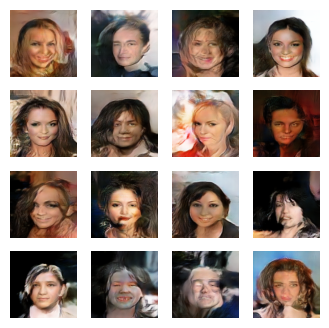

Epoch 2/100 | Generator loss: 6.2066, Discriminator loss: 0.8282 | Time: 49.63 s


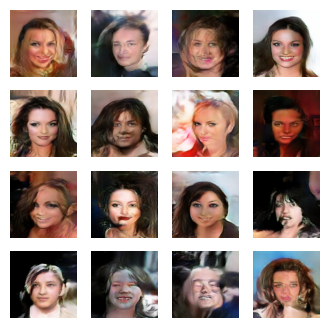

Epoch 3/100 | Generator loss: 6.2362, Discriminator loss: 0.8359 | Time: 49.60 s


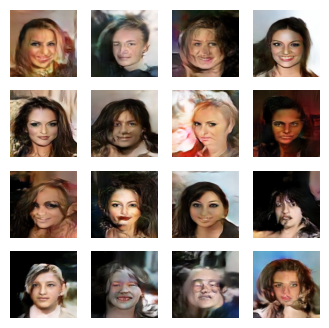

Epoch 4/100 | Generator loss: 6.2085, Discriminator loss: 0.8536 | Time: 49.54 s


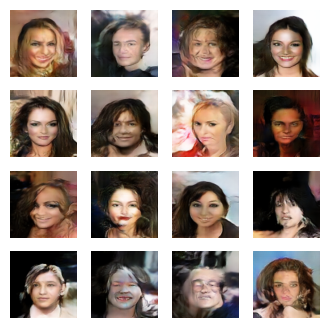

Epoch 5/100 | Generator loss: 6.3095, Discriminator loss: 0.7971 | Time: 49.58 s


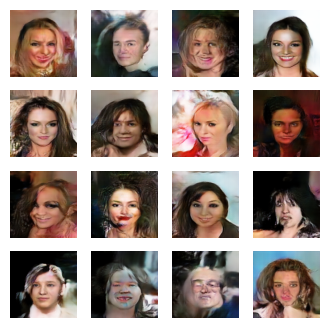

Epoch 6/100 | Generator loss: 6.2661, Discriminator loss: 0.7999 | Time: 49.78 s


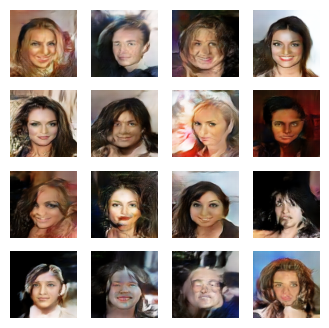

Epoch 7/100 | Generator loss: 6.3142, Discriminator loss: 0.8111 | Time: 49.43 s


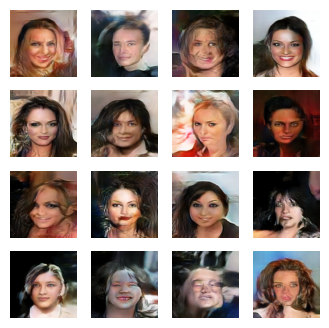

Epoch 8/100 | Generator loss: 6.4752, Discriminator loss: 0.8508 | Time: 49.51 s


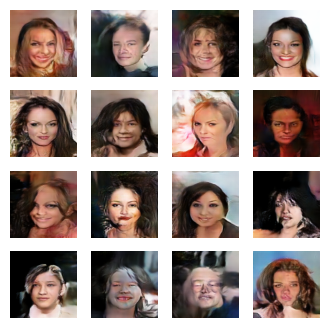

Epoch 9/100 | Generator loss: 6.3164, Discriminator loss: 0.8311 | Time: 49.69 s


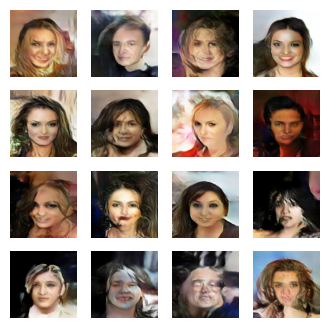

In [ ]:
train(dataset, 100)
generator.save('generator_800.h5')

## Project Summary

This notebook implements a Generative Adversarial Network (GAN) using TensorFlow to generate images. The code includes:

-   Data loading and preprocessing (initially for CelebA, later modified for Oxford Flowers).
-   Definition of the generator and discriminator models.
-   Implementation of loss functions and optimizers.
-   A `train_step` function for updating the generator and discriminator weights.
-   A `generate_and_show_images` function to visualize the generator's progress.
-   Setup for distributed training using `tf.distribute.MirroredStrategy`.
-   A `train` function to manage the training loop over multiple epochs.
-   A final assignment suggesting modifications for image super-resolution on the CelebA dataset (this can be adapted for the Oxford Flowers dataset).

The goal of this project is to demonstrate the fundamental concepts of GANs and provide a starting point for generating synthetic images or performing image-to-image translation tasks.

## Assignment: Oxford Flowers 102 Image Generator using GANs

Based on the provided code for training a GAN, your assignment is to build a GAN to generate realistic flower images using the Oxford Flowers 102 dataset.

**Task:**

1.  **Data Loading and Preprocessing:**
    *   Ensure the code correctly loads and preprocesses the Oxford Flowers 102 dataset using `tensorflow_datasets`, resizing images to the desired `IMAGE_SHAPE` and normalizing pixel values to [-1, 1]. The current code in cell `cINCGsobBYzc` should handle this.

2.  **Generator Architecture:**
    *   Review and potentially modify the `build_generator` function to ensure it is suitable for generating flower images. The current architecture is designed for 128x128 images and should be a good starting point. The input will be a noise vector.

3.  **Discriminator Architecture:**
    *   Review and potentially modify the `build_discriminator` function. The current architecture is designed for 128x128 images and should also be a good starting point. Its role is to distinguish between real flower images from the dataset and fake flower images generated by the generator.

4.  **Loss Functions and Optimizers:**
    *   Ensure the `generator_loss` and `discriminator_loss` functions, and the optimizers (`gen_optimizer`, `disc_optimizer`) are correctly defined for the GAN training process. The current setup in cell `kQEmbCt7BYzd` and `lVYSVXRnBYze` should be appropriate.

5.  **Training:**
    *   Use the provided `train_step` and `train` functions (potentially using the distributed training setup) to train the GAN on the preprocessed Oxford Flowers 102 dataset.

6.  **Evaluation and Visualization:**
    *   Utilize the `generate_and_show_images` function to visualize the progress of the generator during training by generating sample flower images from a fixed noise vector.
    *   After training, visually evaluate the quality and diversity of the generated flower images.

**Deliverables:**

*   The modified Python notebook with the working code for the flower image generator.
*   A brief report (can be a markdown section in the notebook) describing:
    *   Any significant modifications made to the generator or discriminator architectures.
    *   Observations during training (e.g., convergence, quality of generated images over epochs).
    *   Examples of generated flower images after training.
    *   Any challenges encountered during the process.

**Tips:**

*   Ensure the data preprocessing correctly scales and normalizes the image data.
*   Monitor the generator and discriminator losses during training to understand the GAN's progress.
*   Experiment with the number of epochs to find a good balance between training time and generated image quality.
*   Adjust hyperparameters like learning rates if needed.

In [ ]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7BUSRN_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7BUSRN_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7BUSRN_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see